# Análise de séries temporais com Python
## Estudo com o índice de vendas - hipermercados e supermercados de São Paulo a partir do método SARIMA.

In [1]:
# Importação das bibliotecas utilizadas

import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima 

import numpy as np
import warnings

from bcb import sgs

from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
# Filtro de warnings
warnings.filterwarnings('ignore')

In [3]:
# Função para coleta dos dados do banco do BACEN 
def getBacenIndexes():  
    '''
    Código da série temporal: 1503 - obtido no site: https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries
    '''  
    df = sgs.get({'Índice de vendas - Hipermercados e supermercados- SP': 1503 }
                  ,start='2000-01-01', end='2022-12-01')      
    return df

In [4]:
# Execução da função
series = getBacenIndexes()

<Axes: xlabel='Ano'>

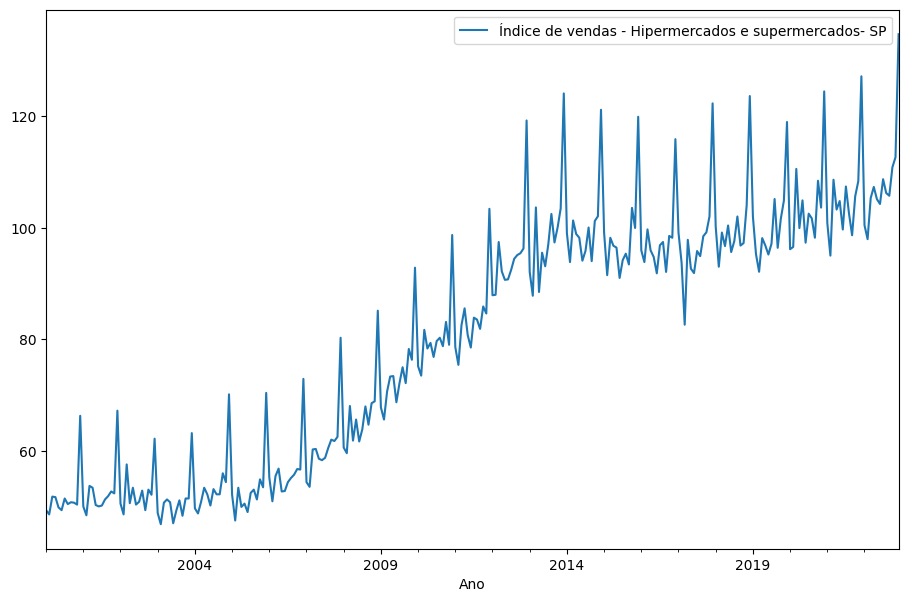

In [5]:
# visualização dos índices ao longos dos anos 2000 até 2022
series.plot(xlabel="Ano", figsize=(11,7))

## Decomposição da série temporal

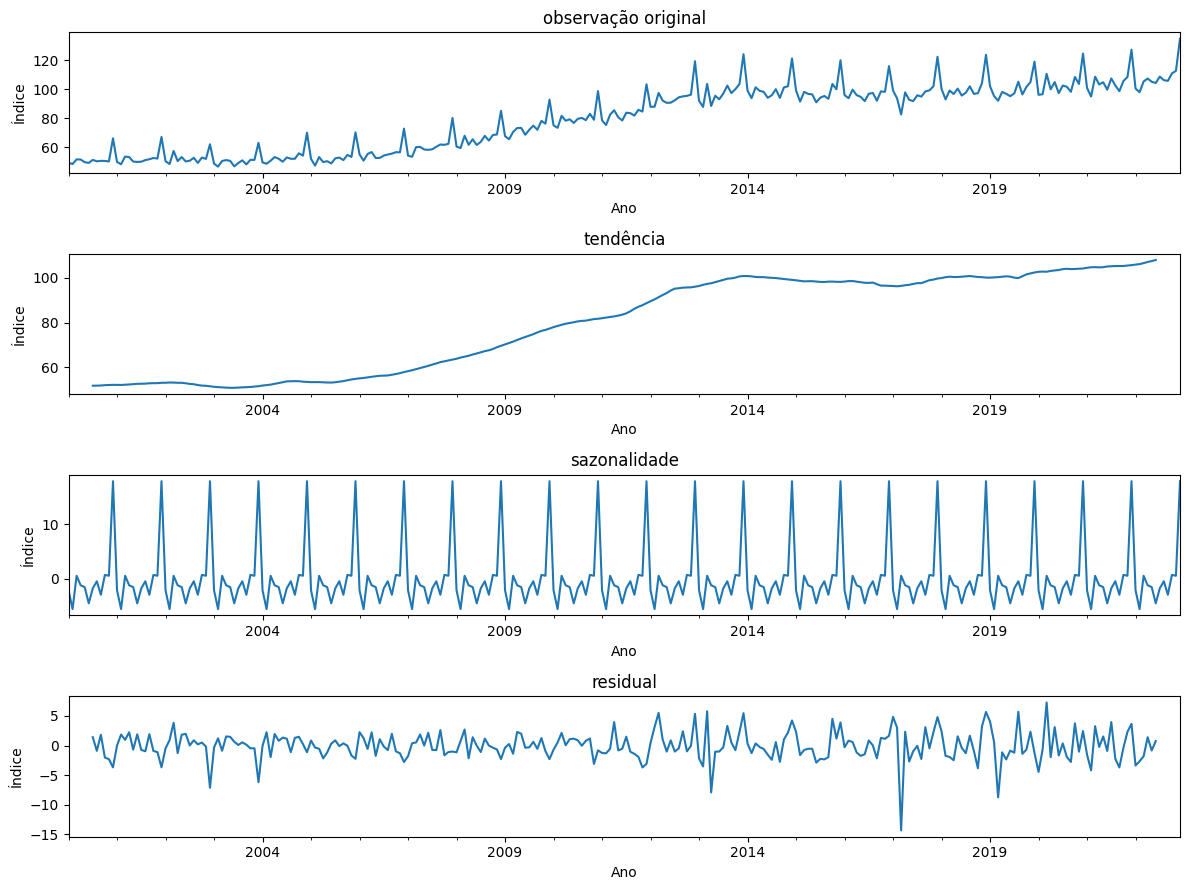

In [6]:
# Analisando os componentes da série temporal

result = seasonal_decompose(series)

fig, (ax1,ax2,ax3,ax4) = pyplot.subplots(4,1, figsize=(12,9))

result.observed.plot(ax=ax1, title="observação original", ylabel='Índice', xlabel='Ano')
result.trend.plot(ax=ax2, title="tendência", ylabel='Índice', xlabel='Ano')
result.seasonal.plot(ax=ax3, title="sazonalidade", ylabel='Índice', xlabel='Ano')
result.resid.plot(ax=ax4, title="residual", ylabel='Índice', xlabel='Ano')

pyplot.tight_layout()

<Axes: xlabel='Date'>

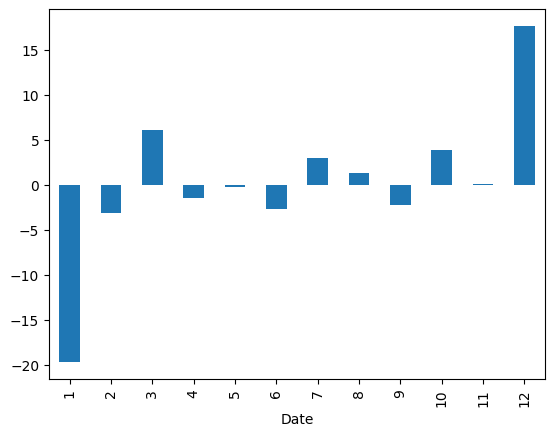

In [7]:
# Gráfico para identificação de valores sazonais 
# Forte sazonalidade para os meses de dezembro e janeiro

series['Índice de vendas - Hipermercados e supermercados- SP'].diff().groupby(series.index.month).mean().plot(kind='bar')

## Verificação das funções de autocorrelação (ACF) e autocorrelação parcial (PACF) da série.

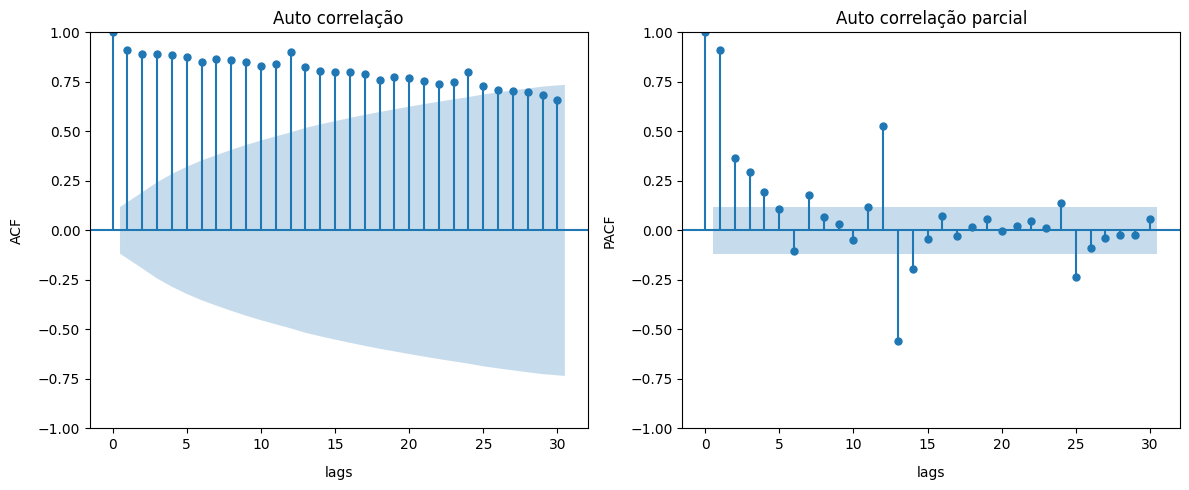

In [8]:
# Gráfico de autocorrelação total e parcial do Índice de vendas - Hipermercados e supermercados- SP.

fig, (ax1,ax2) = pyplot.subplots(1,2, figsize=(12,5))

plot_acf(series, ax=ax1, lags=30)
ax1.set_title('Auto correlação')
ax1.set_ylabel('ACF', labelpad=10, fontsize=10)
ax1.set_xlabel('lags', labelpad=10, fontsize=10)

plot_pacf(series, ax=ax2, lags=30)
ax2.set_title('Auto correlação parcial')
ax2.set_ylabel('PACF', labelpad=10, fontsize=10)
ax2.set_xlabel('lags', labelpad=10, fontsize=10)

pyplot.tight_layout()


## Teste de estacionaridade da série. Aplicação do teste ADF.

### Fórmula do teste Dickey-Fuller Aumentado
$$
∇Yt = α_1 + α_2t + γY_(t-1) + u_t  
$$

In [9]:
ad_fuller_test = sm.tsa.adfuller(series['Índice de vendas - Hipermercados e supermercados- SP'])

In [10]:
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(ad_fuller_test[0]))
print('Valor-p: {:.4f}'.format(ad_fuller_test[1]))
print('Number of lags used: {:.4f}'.format(ad_fuller_test[2]))
print('Valores Críticos:')
for key, value in ad_fuller_test[4].items():
	print('\t{}: {:.4f}'.format(key, value))
 
teste = {("Não estacionária" if ad_fuller_test[0] > value else "Estacionária"): value for key, value in ad_fuller_test[4].items()}
print('O teste Dickey-Fuller Aumentado mostra que a série é: {}'.format(list(teste.keys())[0]))

Dickey-Fuller Aumentado
Teste Estatístico: -0.3723
Valor-p: 0.9146
Number of lags used: 14.0000
Valores Críticos:
	1%: -3.4557
	5%: -2.8727
	10%: -2.5727
O teste Dickey-Fuller Aumentado mostra que a série é: Não estacionária


<Axes: xlabel='Date'>

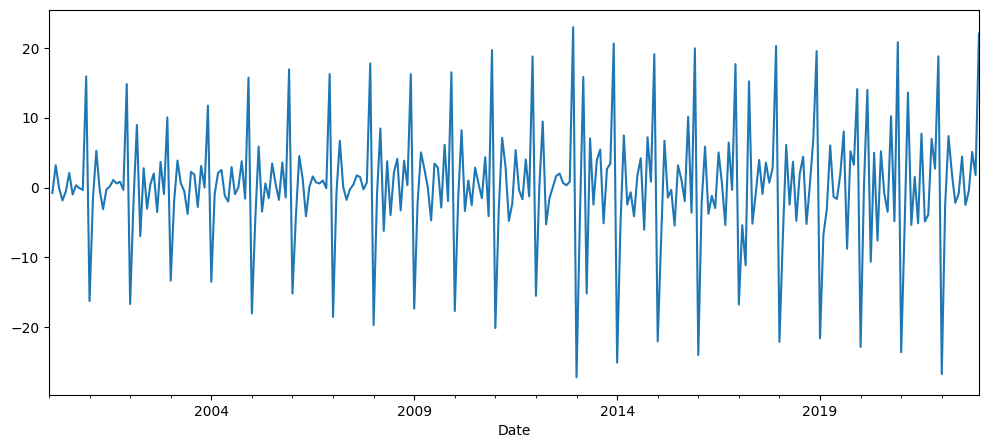

In [11]:
# Tranformar a série em estacionária para reproduzir o comportamento 
# do d (I do arIma) na diferenciação utilizada no método ARIMA

dif_series = series['Índice de vendas - Hipermercados e supermercados- SP'].diff()
dif_series.plot(figsize=(12,5))

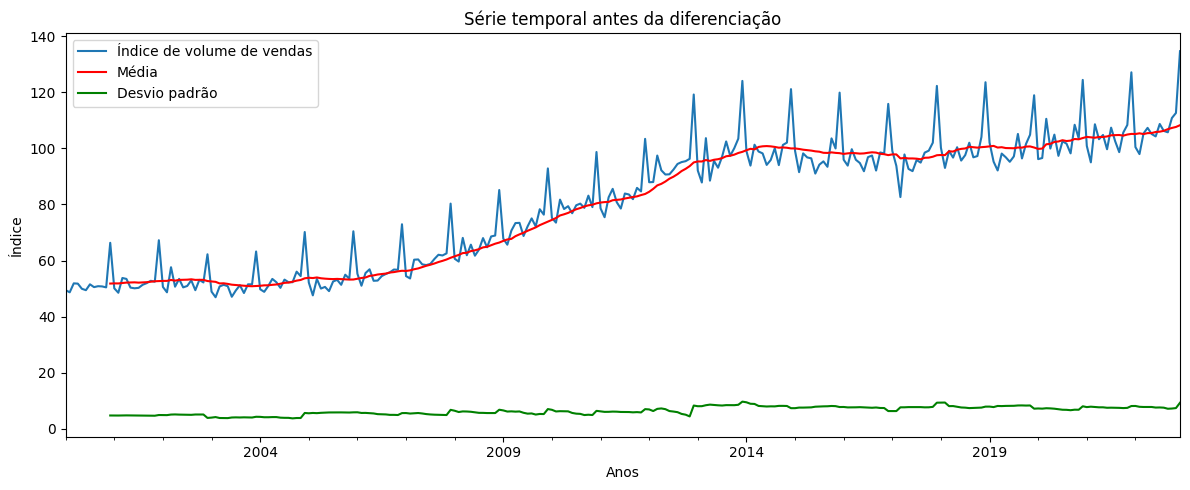

In [12]:
# Visualização da série antes da diferenciação
ma_ = series.rolling(12).mean()
std_ = series.rolling(12).std()

#plotar a diferenciação
fig, ax = pyplot.subplots(figsize=(12,5))
ax.set_title('Série temporal antes da diferenciação')
series.plot(ax=ax)
ma_.plot(ax=ax, color='r')
std_.plot(ax=ax, color='g')
ax.legend(['Índice de volume de vendas', 'Média', 'Desvio padrão'])
ax.set_ylabel('Índice', fontsize=10)
ax.set_xlabel('Anos', fontsize=10)
pyplot.tight_layout()

## Transformação da série temporal não estacionária em estacionária.

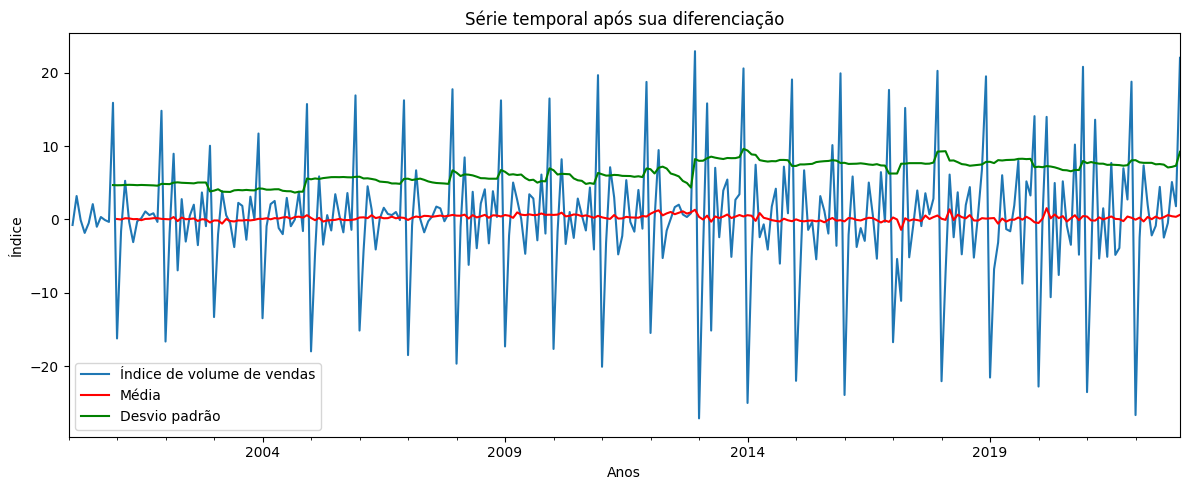

In [13]:
#aplicar diferenciação
df_diff = series.diff(1)
ma_diff = df_diff.rolling(12).mean()
ma_std = series.rolling(12).std()

#plotar a diferenciação
fig, ax = pyplot.subplots(figsize=(12,5))
ax.set_title('Série temporal após sua diferenciação')
df_diff.plot(ax=ax)
ma_diff.plot(ax=ax, color='r')
ma_std.plot(ax=ax, color='g')
ax.legend(['Índice de volume de vendas', 'Média', 'Desvio padrão'])
ax.set_ylabel('Índice', fontsize=10)
ax.set_xlabel('Anos', fontsize=10)
pyplot.tight_layout()

In [14]:
# Eliminação dos valores nulos
series_after_diff = df_diff.dropna().values

In [15]:
df_diff = series.diff(1)
series_after_diff = df_diff.dropna().values

ad_fuller_test = sm.tsa.adfuller(series_after_diff)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(ad_fuller_test[0]))
print('Valor-p: {:.4f}'.format(ad_fuller_test[1]))
print('Number of lags used: {:.4f}'.format(ad_fuller_test[2]))
print('Valores Críticos:')
for key, value in ad_fuller_test[4].items():
	print('\t{}: {:.4f}'.format(key, value))
 
teste = {("Não estacionária" if ad_fuller_test[0] > value else "Estacionária"): value for key, value in ad_fuller_test[4].items()}
print('O teste Dickey-Fuller Aumentado mostra que a série é: {}'.format(list(teste.keys())[0]))

Dickey-Fuller Aumentado
Teste Estatístico: -3.6528
Valor-p: 0.0048
Number of lags used: 13.0000
Valores Críticos:
	1%: -3.4557
	5%: -2.8727
	10%: -2.5727
O teste Dickey-Fuller Aumentado mostra que a série é: Estacionária


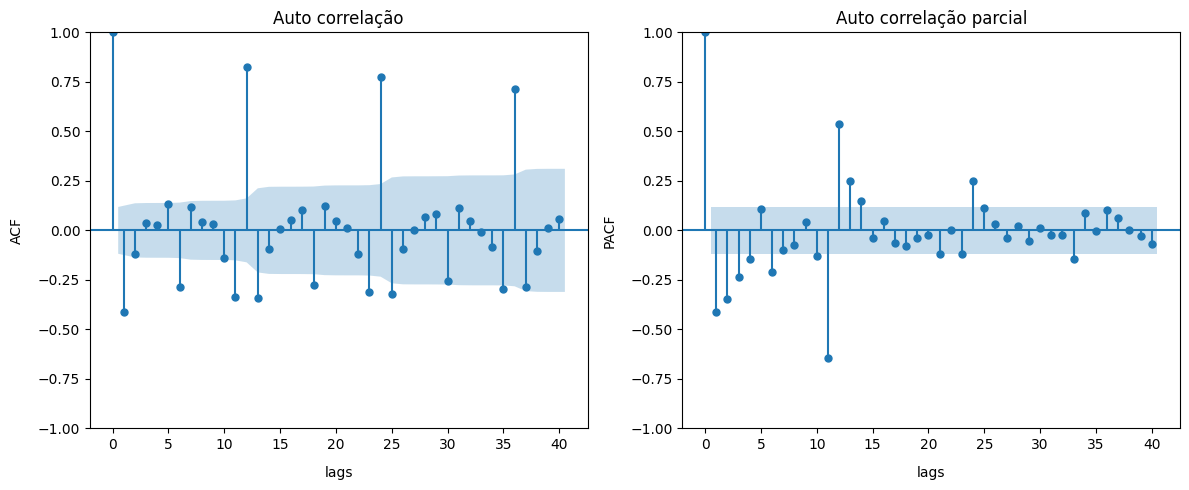

In [16]:
# Gráfico de autocorrelação total e parcial do índice de vendas após a diferenciação da série.

df_diff_1 = series.diff(1)
series_after_diff = df_diff_1.dropna().values

fig, (ax1,ax2) = pyplot.subplots(1,2, figsize=(12,5))

plot_acf(series_after_diff, ax=ax1, lags=40)
ax1.set_title('Auto correlação')
ax1.set_ylabel('ACF', labelpad=10, fontsize=10)
ax1.set_xlabel('lags', labelpad=10, fontsize=10)

plot_pacf(series_after_diff, ax=ax2, lags=40)
ax2.set_title('Auto correlação parcial')
ax2.set_ylabel('PACF', labelpad=10, fontsize=10)
ax2.set_xlabel('lags', labelpad=10, fontsize=10)

pyplot.tight_layout()

## Execução do auto_arima para obter o melhor modelo ARIMA sazonal de forma automática.
### Os parâmetros informados no modelo são observados nas funções de autocorrelação total e parcial e teste de estacionaridade.

In [17]:
stepwise = auto_arima(series['Índice de vendas - Hipermercados e supermercados- SP'],
                          start_p = 0, #parâmetro de início do componente de autorregração.
                          start_q = 0, #parâmetro de início do componente de médias móveis.
                          max_p = 25, #parâmetro máximo do componente de autorregração.
                          max_q = 40, #parâmetro máximo do componente de média móvel.
                          m = 12, #parâmetro para a diferenciação sazonal (12 para sazonalidade mensal).
                          start_P = 0, #parâmetro de início do componente de autorregração sazonal.
                          seasonal = True, 
                          d = 1, #parâmetro da primeira diferenciação da série.
                          D = 1, #ordem do parâmetro de diferenciação sazonal.
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True)           
  

stepwise.summary() 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1436.173, Time=0.36 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1544.694, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1398.976, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1323.838, Time=0.33 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1412.137, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1323.079, Time=0.96 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1354.240, Time=0.44 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1323.311, Time=2.47 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1324.486, Time=3.92 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1323.670, Time=1.70 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1348.278, Time=0.59 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=1324.809, Time=4.30 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1436.228, Time=0.64 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1322.484, Time=1.01 sec
 ARIMA(1,1,1)(0,1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  276
Model:             SARIMAX(2, 1, 2)x(2, 1, [1], 12)   Log Likelihood                -651.070
Date:                              Sat, 22 Jun 2024   AIC                           1318.139
Time:                                      08:20:54   BIC                           1346.716
Sample:                                  01-01-2000   HQIC                          1329.624
                                       - 12-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0839      0.093    -11.647      0.000      -1.266      -0.901
ar.L2         -0.2389      0.075     -3.204      0.001      -0.385      -0.093
ma.L1          0.3353      0.084      4.012      0.000       0.172       0.499
ma.L2         -0.5421      0.086     -6.311      0.000      -0.711      -0.374
ar.S.L12       0.1886      0.100      1.887      0.059      -0.007       0.385
ar.S.L24       0.1087      0.076      1.435      0.151      -0.040       0.257
ma.S.L12      -0.8440      0.070    -11.998      0.000      -0.982      -0.706
sigma2         7.9430      0.477     16.641      0.000       7.007       8.879
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               579.94
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               4.42   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Execução do modelo SARIMA de treino.

In [18]:
# Avaliação pelo modelo SARIMA
# Melhor modelo:  SARIMA(2,1,2)(2,1,1)[12] 
sarima_model = sm.tsa.statespace.SARIMAX(series, freq='MS', order=(2, 1, 2), seasonal_order=(2, 1, 1, 12)).fit()
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                SARIMAX Results                                                 
================================================================================================================
Dep. Variable:     Índice de vendas - Hipermercados e supermercados- SP   No. Observations:                  276
Model:                                 SARIMAX(2, 1, 2)x(2, 1, [1], 12)   Log Likelihood                -651.070
Date:                                                  Sat, 22 Jun 2024   AIC                           1318.139
Time:                                                          08:21:08   BIC                           1346.716
Sample:                                                      01-01-2000   HQIC                          1329.624
                                                           - 12-01-2022                                         
Covariance Type:                                                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0839      0.093    -11.647      0.000      -1.266      -0.901
ar.L2         -0.2389      0.075     -3.204      0.001      -0.385      -0.093
ma.L1          0.3353      0.084      4.012      0.000       0.172       0.499
ma.L2         -0.5421      0.086     -6.311      0.000      -0.711      -0.374
ar.S.L12       0.1886      0.100      1.887      0.059      -0.007       0.385
ar.S.L24       0.1087      0.076      1.435      0.151      -0.040       0.257
ma.S.L12      -0.8440      0.070    -11.998      0.000      -0.982      -0.706
sigma2         7.9430      0.477     16.641      0.000       7.007       8.879
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               579.94
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               4.42   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Visualização da série temporal e dos resultados previstos pelo modelo a partir do ano de 2021.

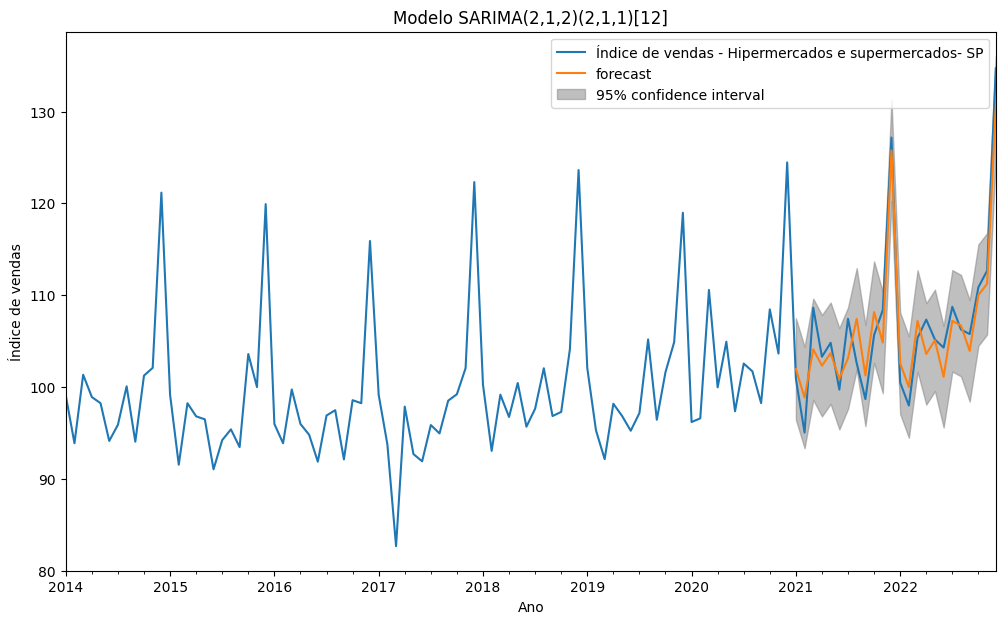

In [19]:
# Visualização do modelo:  SARIMA(2,1,2)(2,1,1)[12]

fig, ax = pyplot.subplots(figsize=(12,7))
ax = series.loc['2014-01-01':].plot(ax=ax)
ax.set_title('Modelo SARIMA(2,1,2)(2,1,1)[12]')
ax.set_ylabel('Índice de vendas', fontsize=10)
ax.set_xlabel('Ano', fontsize=10)
plot_predict(sarima_model, '2021-01-01', '2022-12-01', ax=ax)
pyplot.show()

## Descrição e visualização dos resíduos do modelo SARIMA(2,1,2)(2,1,1)[12].

                0
count  276.000000
mean     0.190920
std      4.860430
min    -40.944890
25%     -1.155683
50%      0.245776
75%      1.482293
max     49.410000


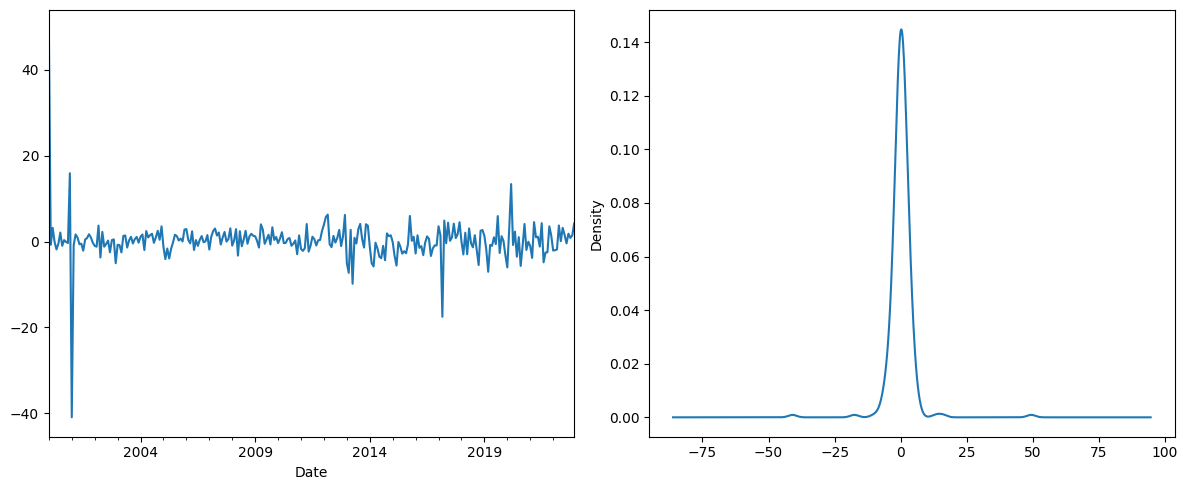

In [20]:
fig, (ax1,ax2) = pyplot.subplots(1,2, figsize=(12,5))

sarima_residuals = pd.DataFrame(sarima_model.resid)
sarima_residuals.plot(ax=ax1,legend=False)

sarima_residuals = pd.DataFrame(sarima_model.resid)
sarima_residuals.plot(ax=ax2,kind='kde',legend=False)

pyplot.tight_layout()
print(sarima_residuals.describe())

## Descrição e visualização dos resíduos dos dados de teste do modelo SARIMA(2,1,2)(2,1,1)[12].

               0
count  36.000000
mean    0.417591
std     3.636279
min    -6.028956
25%    -1.971380
50%     0.468978
75%     2.482988
max    13.382985


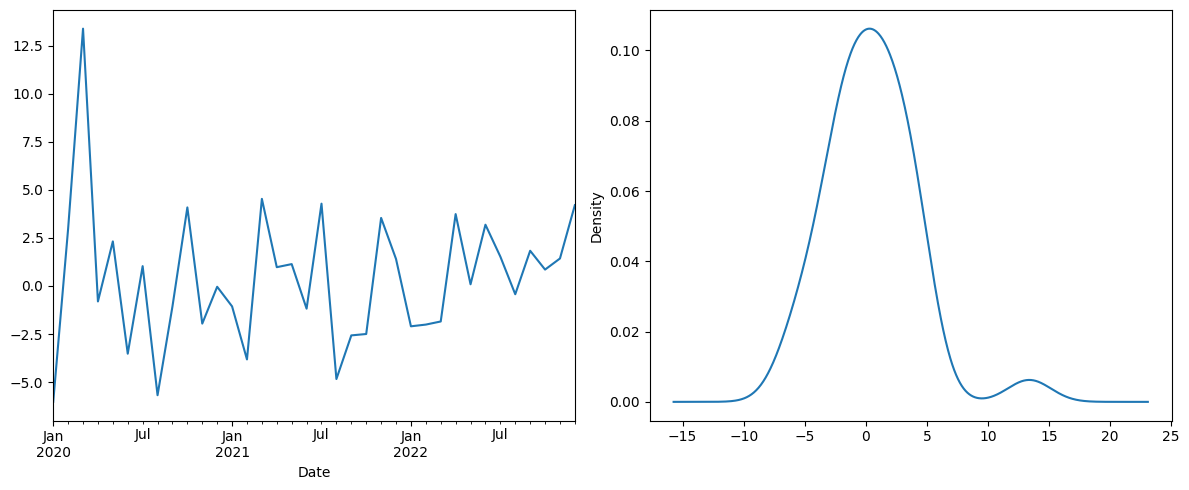

In [22]:
test_residuals = sarima_residuals[(sarima_residuals.index >= '2020-01-01')]

fig, (ax1,ax2) = pyplot.subplots(1,2, figsize=(12,5))

sarima_residuals = pd.DataFrame(test_residuals)
sarima_residuals.plot(ax=ax1,legend=False)

sarima_residuals = pd.DataFrame(test_residuals)
sarima_residuals.plot(ax=ax2,kind='kde',legend=False)

pyplot.tight_layout()
print(sarima_residuals.describe())


# Execução de um modelo ARIMA para comparação com o modelo anterior.

## Execução do auto_arima para obter o melhor modelo ARIMA de forma automática.
### Os parâmentros informados no modelo são observados nas funções de autocorrelação total e parcial e teste de estacionaridade.

In [23]:
Arima_stepwise = auto_arima(series['Índice de vendas - Hipermercados e supermercados- SP'],
                          start_p = 0, #parâmetro inicial do componente de auto regração.
                          start_q = 0, #parâmetro inicial do compoente de média móvel.
                          max_p = 25, #parâmetro máximo do componente de auto regração.
                          max_q = 40, #parâmetro máximo do componente de média móvel.
                          seasonal = False, #seasonal = False para obter um modelo ARIMA.
                          d = 1, #parâmetro de diferenciação da série.
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True)           
  

Arima_stepwise.summary() 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1975.208, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1925.208, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1846.127, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1973.556, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1847.345, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1847.155, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1846.780, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1854.599, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.751 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  276
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -920.064
Date:                Sun, 16 Jun 2024   AIC                           1846.127
Time:                        14:20:35   BIC                           1856.978
Sample:                    01-01-2000   HQIC                          1850.482
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2299      0.084      2.721      0.007       0.064       0.395
ma.L1         -0.8555      0.037    -23.417      0.000      -0.927      -0.784
sigma2        46.9326      3.399     13.807      0.000      40.271      53.595
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):               261.91
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               2.72   Skew:                             1.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Execução do modelo ARIMA de treino.

In [21]:
arima_model = sm.tsa.arima.ARIMA(series, freq='MS', order=(0,1,1)).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                SARIMAX Results                                                 
================================================================================================================
Dep. Variable:     Índice de vendas - Hipermercados e supermercados- SP   No. Observations:                  276
Model:                                                   ARIMA(0, 1, 1)   Log Likelihood                -925.300
Date:                                                  Sat, 22 Jun 2024   AIC                           1854.599
Time:                                                          08:21:32   BIC                           1861.833
Sample:                                                      01-01-2000   HQIC                          1857.502
                                                           - 12-01-2022                                         
Covariance Type:                                                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8077      0.046    -17.615      0.000      -0.898      -0.718
sigma2        48.8002      2.761     17.674      0.000      43.389      54.212
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               243.64
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               2.76   Skew:                             1.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Visualização da série temporal e dos resultados previstos pelo modelo a partir do ano de 2021.

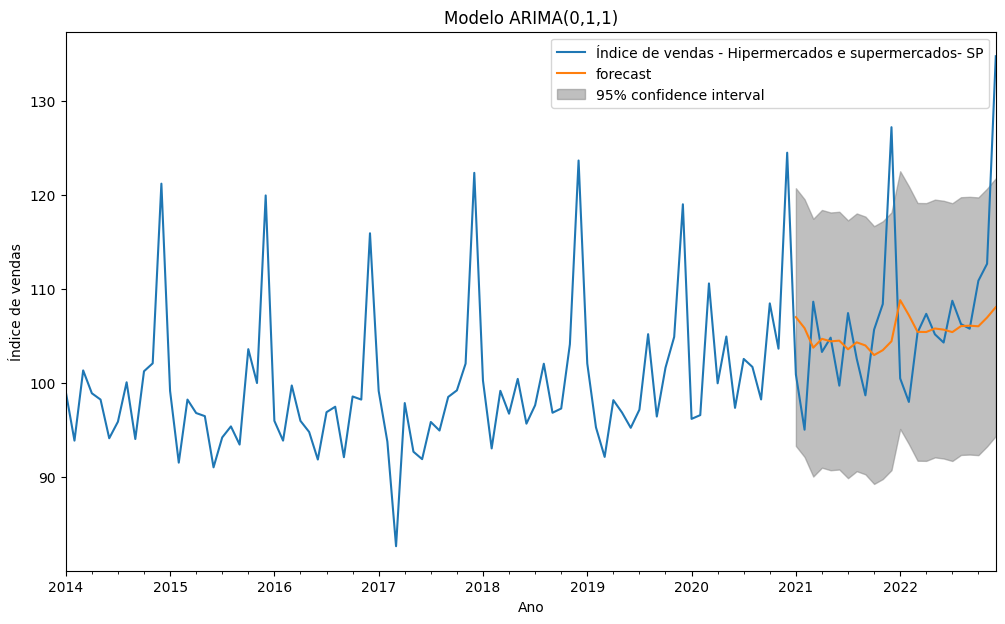

In [22]:
# Visualização do modelo:  ARIMA(0,1,1)

fig, ax = pyplot.subplots(figsize=(12,7))
ax = series.loc['2014-01-01':].plot(ax=ax)
ax.set_title('Modelo ARIMA(0,1,1)')
ax.set_ylabel('Índice de vendas', fontsize=10)
ax.set_xlabel('Ano', fontsize=10)
plot_predict(arima_model, '2021-01-01', '2022-12-01', ax=ax)
pyplot.show()

## Descrição e visualização dos resíduos do modelo ARIMA(0,1,1).

                0
count  276.000000
mean     1.373040
std      7.469754
min    -16.365541
25%     -2.897189
50%      0.344304
75%      2.849668
max     49.410000


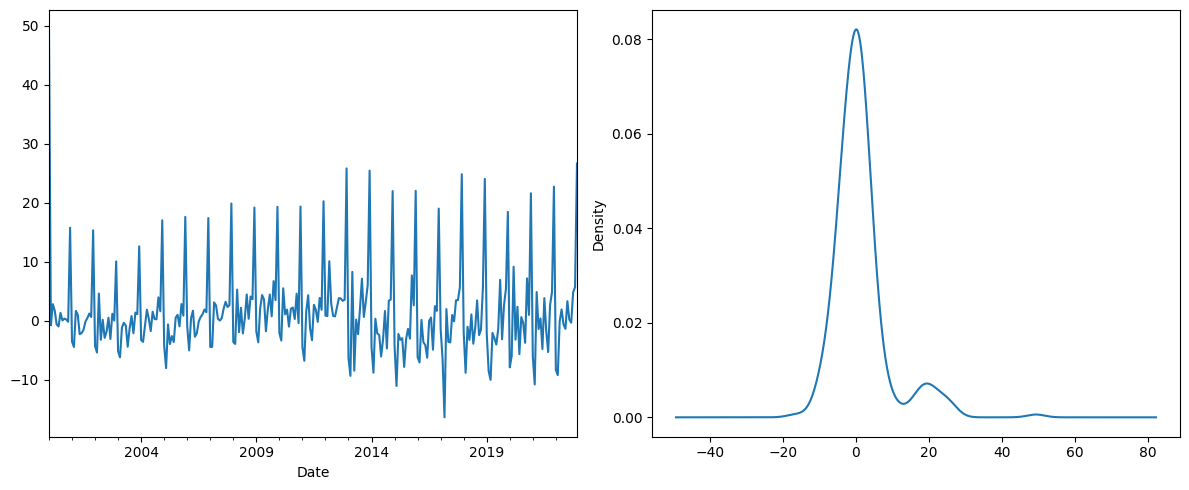

In [23]:
fig, (ax1,ax2) = pyplot.subplots(1,2, figsize=(12,5))

arima_residuals = pd.DataFrame(arima_model.resid)
arima_residuals.plot(ax=ax1,legend=False)

arima_residuals = pd.DataFrame(arima_model.resid)
arima_residuals.plot(ax=ax2,kind='kde',legend=False)

pyplot.tight_layout()
print(arima_residuals.describe())

## Análise comparativa dos resíduos dos modelos ARIMA e SARIMA

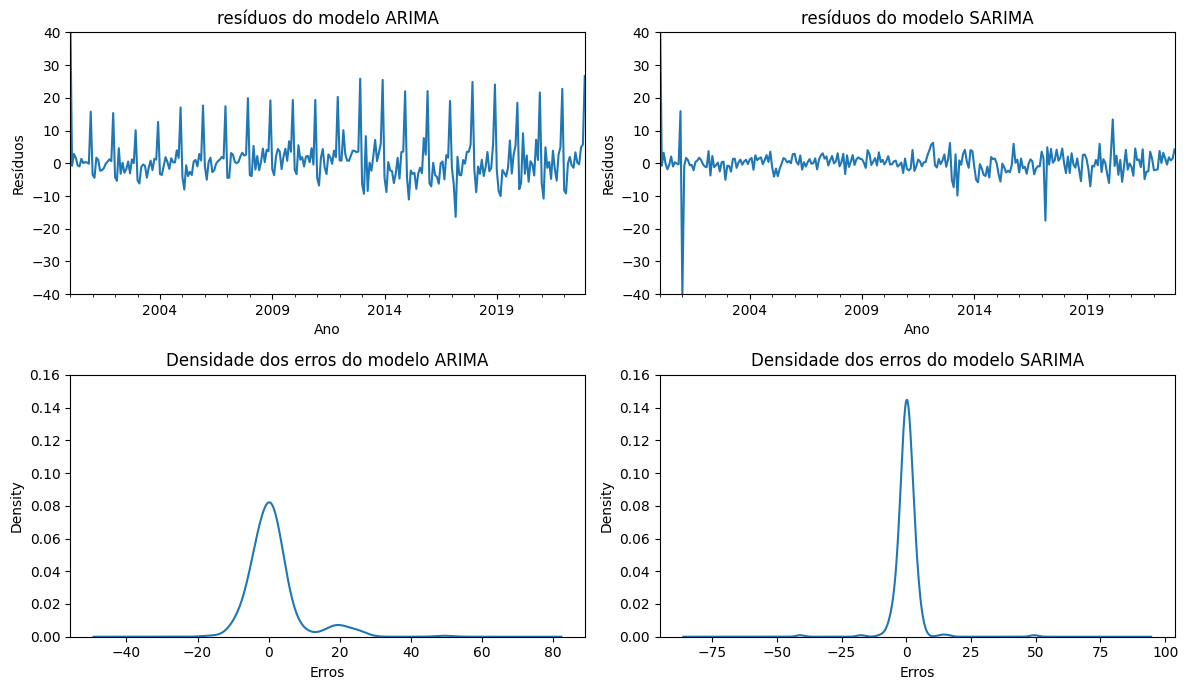

In [24]:
fig, (ax1) = pyplot.subplots(2,2, figsize=(12,7))

ARIMA_residuals = pd.DataFrame(arima_model.resid)
SARIMA_residuals = pd.DataFrame(sarima_model.resid)


ax1[0,0].set_ylabel('Resíduos')
ax1[0,0].set_ylim(-40,40)
ax1[0,1].set_ylabel('Resíduos')
ax1[0,1].set_ylim(-40,40)
ax1[1,0].set_xlabel('Erros')
ax1[1,0].set_ylim(0,0.16)
ax1[1,1].set_xlabel('Erros')
ax1[1,1].set_ylim(0,0.16)

ARIMA_residuals.plot(ax=ax1[0,0], title='resíduos do modelo ARIMA', xlabel='Ano' ,legend=False)
SARIMA_residuals.plot(ax=ax1[0,1], title='resíduos do modelo SARIMA', xlabel='Ano', legend=False)
ARIMA_residuals.plot(ax=ax1[1,0], kind='kde', title='Densidade dos erros do modelo ARIMA', legend=False)
SARIMA_residuals.plot(ax=ax1[1,1], kind='kde', title='Densidade dos erros do modelo SARIMA', legend=False)

pyplot.tight_layout()

In [35]:
# Análise descritiva comparativa dos resíduos dos modelos ARIMA e SARIMA

df_resid_arima = arima_residuals.describe()
df_resid_sarima = sarima_residuals.describe()

residuos_combined = pd.concat([df_resid_arima, df_resid_sarima], axis=1)
residuos_combined.columns = ['Resíduos ARIMA', 'Resíduos SARIMA']
print(residuos_combined)

       Resíduos ARIMA  Resíduos SARIMA
count      276.000000       276.000000
mean         1.373040         0.190920
std          7.469754         4.860430
min        -16.365541       -40.944890
25%         -2.897189        -1.155683
50%          0.344304         0.245776
75%          2.849668         1.482293
max         49.410000        49.410000


## Avaliação dos modelos através da comparação de resultados pelo erro absoluto médio percentual [MAPE].

### O erro absoluto médio percentual [MAPE] quantifica a precisão da previsão como uma porcentagem, relacionando o erro da previsão ao nível de demanda. Sua utilidade reside na capacidade de permitir comparações entre previsões independentemente dos dados.

$$
MAPE=  (∑_(t=1)^n▒|E_t/D_t |100)/n
$$

In [30]:
#Avaliação do MAPE para os modelos observados.
arima_mape = np.mean(np.abs(arima_model.predict().values - series.values) / np.abs(series.values))
sarima_mape = np.mean(np.abs(sarima_model.predict().values - series.values) / np.abs(series.values))

print(
  {
    "Arima MAPE": arima_mape,
    "Sarima_MAPE": sarima_mape
  }
)

{'Arima MAPE': 0.3414611079773903, 'Sarima_MAPE': 0.3518973849540988}
